In [1]:
from typing import TypedDict
class My_StateGraph(TypedDict):
    amount_usd: float
    total_usd: float
    amount_pkr: float

In [2]:
def cal_usd(state: My_StateGraph) -> My_StateGraph:
    state['total_usd'] = state['amount_usd'] + 80
    return state

def cal_pkr(state: My_StateGraph) -> My_StateGraph:
    state['amount_pkr'] = state['total_usd'] * 280
    return state

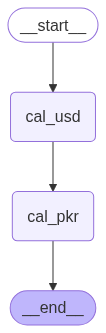

In [3]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(My_StateGraph)

builder.add_node("cal_usd", cal_usd)
builder.add_node("cal_pkr", cal_pkr)

builder.add_edge(START, "cal_usd")
builder.add_edge("cal_usd", "cal_pkr")
builder.add_edge("cal_pkr", END)

graph = builder.compile()

graph

In [4]:
graph.invoke({"amount_usd": 100.0})

{'amount_usd': 100.0, 'total_usd': 180.0, 'amount_pkr': 50400.0}

--------
# Conditional Graph

In [5]:
from typing import TypedDict, Literal
class My_StateGraph(TypedDict):
    amount_usd: float
    total_usd: float
    currency: Literal['PKR', 'INR']
    amount: float

In [6]:
def cal_usd(state: My_StateGraph) -> My_StateGraph:
    state['total_usd'] = state['amount_usd'] + 80
    return state

def cal_PKR(state: My_StateGraph) -> My_StateGraph:
    state['amount'] = state['total_usd'] * 280
    return state

def cal_INR(state: My_StateGraph) -> My_StateGraph:
    state['amount'] = state['total_usd'] * 80
    return state

def choose_currency(state: My_StateGraph) -> str:
    return state['currency']

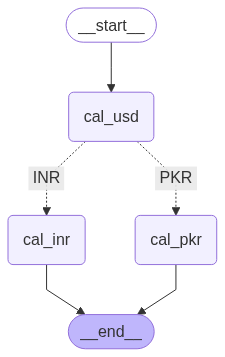

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(My_StateGraph)

builder.add_node("cal_usd", cal_usd)
builder.add_node("cal_pkr", cal_PKR)
builder.add_node("cal_inr", cal_INR)

builder.add_edge(START, "cal_usd")
builder.add_conditional_edges(
    "cal_usd",
    choose_currency,
    {
        'PKR': "cal_pkr",
        "INR": "cal_inr"
    }
)
builder.add_edge(["cal_pkr", "cal_inr"], END)

graph = builder.compile()

graph

In [8]:
graph.invoke({"amount_usd": 100.0, "currency":"PKR"})

{'amount_usd': 100.0, 'total_usd': 180.0, 'currency': 'PKR', 'amount': 50400.0}

-------
# LLM WorkFlow

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")

In [2]:
from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client(api_key=api_key)

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

AI learns from data to recognize patterns and make intelligent decisions or predictions.


In [5]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [13]:
class LLM_Graph(TypedDict):
    question: str
    answer: str


def llm_response(state: LLM_Graph) -> LLM_Graph:
    question = state['question']

    prompt = f"Answer the following question:\n{question}\nAnswer must very brief and to the point"

    response = client.models.generate_content(
    model="gemini-2.5-flash", contents=prompt
    )

    state['answer'] = response.text

    return state

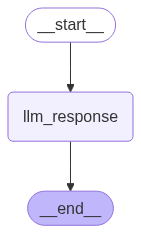

In [14]:
builder = StateGraph(LLM_Graph)

builder.add_node("llm_response", llm_response)

builder.add_edge(START, "llm_response")
builder.add_edge("llm_response", END)

graph = builder.compile()

graph

In [15]:
input = ({"question":"What is AI."})

output = graph.invoke(input)
output

{'question': 'What is AI.',
 'answer': 'AI is intelligence demonstrated by machines.'}